In [ ]:
import cv2
import os
from tqdm.notebook import tqdm
from pathlib import Path
from IPython.display import display, clear_output
from diffusers import StableDiffusion3ControlNetPipeline, SD3ControlNetModel, SD3CannyImageProcessor
from diffusers import DDPMScheduler
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, ToTensor, Resize
from transformers import CLIPTextModel, CLIPTokenizer

In [5]:
import kagglehub

dataset_path = kagglehub.dataset_download("jehanbhathena/weather-dataset")

In [6]:
image_paths = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.lower().endswith(('.jpg')):
            image_paths.append(os.path.join(root, file))

In [45]:
image_paths[3470]

'/root/.cache/kagglehub/datasets/jehanbhathena/weather-dataset/versions/3/dataset/fogsmog/4357.jpg'

In [7]:
def create_bw_dataset(image_paths, output_dir):
	clear_output()
	if not os.path.exists(output_dir):
		os.makedirs(output_dir)
	if not os.path.exists(Path(output_dir) / "train"):
		os.makedirs(Path(output_dir) / "train")
	if not os.path.exists(Path(output_dir) / "train_colored"):
		os.makedirs(Path(output_dir) / "train_colored")
	progress_bar = tqdm(total=len(image_paths), desc="Creating bw images", unit="image")
	for image_id in range(len(image_paths)):
		try:
			image = cv2.imread(image_paths[image_id])
			gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
		except Exception:
			print(f"Error reading image {image_paths[image_id]}")
			progress_bar.update(1)
			continue
		for x in range(len(gray)):
			for y in range(len(gray[x])):
				if gray[x][y] < 128:
					gray[x][y] = 0
				else:
					gray[x][y] = 255
		cv2.imwrite(Path(output_dir) / "train" / f"img{image_id}.jpg", gray)
		cv2.imwrite(Path(output_dir) / "train_colored" / f"img{image_id}.jpg", image)
		progress_bar.update(1)
	progress_bar.close()

In [ ]:
create_bw_dataset(image_paths, "dataset")

In [1]:
import os
from pathlib import Path
import torch
from diffusers import ControlNetModel, UNet2DConditionModel, AutoencoderKL
from diffusers import DDPMScheduler
from diffusers.optimization import get_scheduler
from accelerate import Accelerator
from torch.utils.data import DataLoader, Dataset
from PIL import Image
import numpy as np
import glob
from safetensors.torch import load_file
from transformers import CLIPTokenizer, CLIPTextModel
from torch import nn

# Ścieżki lokalne
ckpt_path = Path("./../Juggernaut-XL-v9")
controlnet_path = Path("control-lora-recolor-rank256.safetensors")
output_dir = Path("./controlnet_recolor_finetuned")
output_dir.mkdir(exist_ok=True)
dtype = torch.float16

# Wczytywanie UNet i wag z safetensors
unet = UNet2DConditionModel.from_config(ckpt_path / "unet/config.json")
unet_ckpt = load_file(ckpt_path / "unet/diffusion_pytorch_model.safetensors")
unet.load_state_dict(unet_ckpt, strict=False)

# Wczytywanie VAE
vae = AutoencoderKL.from_config(ckpt_path / "vae/config.json")
vae_ckpt = load_file(ckpt_path / "vae/diffusion_pytorch_model.safetensors")
vae.load_state_dict(vae_ckpt, strict=False)
# Move VAE to float16 for performance
vae.to(dtype)

# Wczytywanie scheduler
scheduler = DDPMScheduler.from_config(ckpt_path / "scheduler/scheduler_config.json")

# Wczytywanie ControlNet z wag
controlnet = ControlNetModel.from_unet(unet)
controlnet_ckpt = load_file(controlnet_path)
controlnet.load_state_dict(controlnet_ckpt, strict=False)

# Dataset
class ColorizationDataset(Dataset):
	def __init__(self, bw_dir, colored_dir):
		self.bw_paths = sorted(glob.glob(f"{bw_dir}/*.jpg"))
		self.color_paths = sorted(glob.glob(f"{colored_dir}/*.jpg"))
		assert len(self.bw_paths) == len(self.color_paths)

	def __len__(self):
		return len(self.bw_paths)

	def __getitem__(self, idx):
		bw = Image.open(self.bw_paths[idx]).convert('RGB')
		color = Image.open(self.color_paths[idx]).convert('RGB')
		size = unet.config.sample_size
		bw = torch.from_numpy(np.array(bw.resize((size, size)))).permute(2, 0, 1).to(dtype) / 255
		color = torch.from_numpy(np.array(color.resize((size, size)))).permute(2, 0, 1).to(dtype) / 255
		return {'bw': bw, 'color': color}

dataset = ColorizationDataset(
	bw_dir=Path('./dataset/train'),
	colored_dir=Path('./dataset/train_colored')
)

train_loader = DataLoader(dataset, batch_size=1, shuffle=True)

# Trening
accelerator = Accelerator(mixed_precision='fp16')
optimizer = torch.optim.AdamW(controlnet.parameters(), lr=1e-5)
total_steps = 1000
lr_scheduler = get_scheduler(
	'linear', optimizer=optimizer,
	num_warmup_steps=50, num_training_steps=total_steps
)

# Load both tokenizers and text encoders
tokenizer = CLIPTokenizer.from_pretrained(str(ckpt_path / "tokenizer"))
text_encoder = CLIPTextModel.from_pretrained(str(ckpt_path / "text_encoder")).to(accelerator.device).eval()

tokenizer_2 = CLIPTokenizer.from_pretrained(str(ckpt_path / "tokenizer_2"))
text_encoder_2 = CLIPTextModel.from_pretrained(str(ckpt_path / "text_encoder_2")).to(accelerator.device).eval()


controlnet, unet, vae, text_encoder, text_encoder_2, scheduler, optimizer, train_loader = accelerator.prepare(
	controlnet, unet, vae, text_encoder, text_encoder_2, scheduler, optimizer, train_loader
)

# Freeze models
vae.requires_grad_(False)
text_encoder.requires_grad_(False)
text_encoder_2.requires_grad_(False)
unet.requires_grad_(False)
controlnet.train()

# SDXL requires two text encoders, so we create a helper function to encode prompts
def encode_prompt(text_input):
    text_input_ids = tokenizer(text_input, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt").input_ids
    text_input_ids_2 = tokenizer_2(text_input, padding="max_length", max_length=tokenizer_2.model_max_length, truncation=True, return_tensors="pt").input_ids

    with torch.no_grad():
        prompt_embeds_out = text_encoder(text_input_ids.to(accelerator.device), output_hidden_states=True)
        prompt_embeds = prompt_embeds_out.hidden_states[-2]
        
        prompt_embeds_out_2 = text_encoder_2(text_input_ids_2.to(accelerator.device), output_hidden_states=True)
        pooled_prompt_embeds = prompt_embeds_out_2.pooler_output
        prompt_embeds_2 = prompt_embeds_out_2.hidden_states[-2]

    prompt_embeds = torch.cat([prompt_embeds, prompt_embeds_2], dim=-1)
    return prompt_embeds, pooled_prompt_embeds


global_step = 0
for batch in train_loader:
	with accelerator.accumulate(controlnet):
		bw = batch['bw'].to(accelerator.device, dtype=dtype)
		target = batch['color'].to(accelerator.device, dtype=dtype)

		# Encode the target image in float16
		with torch.no_grad():
			latents = vae.encode(target).latent_dist.sample()
			latents = latents * vae.config.scaling_factor

		noise = torch.randn_like(latents)
		timesteps = torch.randint(	
			0, scheduler.config.num_train_timesteps,
			(latents.shape[0],), device=accelerator.device
		).long()
		noisy_latents = scheduler.add_noise(latents, noise, timesteps)

		text = ["colorizing"] * bw.shape[0]
		prompt_embeds, pooled_prompt_embeds = encode_prompt(text)

		# SDXL needs add_time_ids
		add_time_ids = torch.tensor([[1024, 1024, 0, 0, 1024, 1024]], device=accelerator.device, dtype=dtype)
		added_cond_kwargs = {"text_embeds": pooled_prompt_embeds, "time_ids": add_time_ids}

		down_block_res_samples, mid_block_res_sample = controlnet(
			noisy_latents,
            timesteps,
            encoder_hidden_states=prompt_embeds,
            controlnet_cond=bw,
            added_cond_kwargs=added_cond_kwargs,
            return_dict=False,
		)

		model_pred = unet(
			noisy_latents,
            timesteps,
			encoder_hidden_states=prompt_embeds,
			added_cond_kwargs=added_cond_kwargs,
			down_block_additional_residuals=down_block_res_samples,
            mid_block_additional_residual=mid_block_res_sample,
		).sample

		loss = torch.nn.functional.mse_loss(model_pred.float(), noise.float(), reduction="mean")
		accelerator.backward(loss)
		optimizer.step()
		lr_scheduler.step()
		optimizer.zero_grad()

		if accelerator.is_main_process:
			if global_step % 10 == 0:
				print(f"Step {global_step}: loss={loss.item():.4f}")

		global_step += 1
		if global_step >= total_steps:
			break
	if global_step >= total_steps:
		break

accelerator.wait_for_everyone()
if accelerator.is_main_process:
	controlnet.save_pretrained(output_dir)
	print('Model zapisany w', output_dir)


2025-07-03 00:53:19.621617: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 00:53:19.799087: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751496799.869846     481 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751496799.889731     481 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-03 00:53:20.074081: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Step 0: loss=0.5213
Step 10: loss=0.6258
Step 10: loss=0.6258
Step 20: loss=0.0120
Step 20: loss=0.0120
Step 30: loss=0.0931
Step 30: loss=0.0931
Step 40: loss=0.1014
Step 40: loss=0.1014
Step 50: loss=0.2454
Step 50: loss=0.2454
Step 60: loss=0.0406
Step 60: loss=0.0406
Step 70: loss=0.0363
Step 70: loss=0.0363
Step 80: loss=0.2529
Step 80: loss=0.2529
Step 90: loss=0.0223
Step 90: loss=0.0223
Step 100: loss=0.0963
Step 100: loss=0.0963
Step 110: loss=0.0522
Step 110: loss=0.0522
Step 120: loss=0.0104
Step 120: loss=0.0104
Step 130: loss=0.5059
Step 130: loss=0.5059
Step 140: loss=0.4865
Step 140: loss=0.4865
Step 150: loss=0.0068
Step 150: loss=0.0068
Step 160: loss=0.0068
Step 160: loss=0.0068
Step 170: loss=0.1549
Step 170: loss=0.1549
Step 180: loss=0.4462
Step 180: loss=0.4462
Step 190: loss=0.2710
Step 190: loss=0.2710
Step 200: loss=0.2981
Step 200: loss=0.2981
Step 210: loss=0.4077
Step 210: loss=0.4077
Step 220: loss=0.3551
Step 220: loss=0.3551
Step 230: loss=0.0670
Step 230

RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


2025-07-03 00:47:11.086831: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-03 00:47:11.151172: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751496431.181555   23755 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751496431.190603   23755 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-07-03 00:47:11.256443: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

Loading models...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Models loaded successfully.
Loading image: ./dataset/train/img0.jpg
Running inference...


  0%|          | 0/25 [00:00<?, ?it/s]

Inference complete.


/repos/diffusers/src/diffusers/image_processor.py:148: RuntimeWarning: invalid value encountered in cast
  images = (images * 255).round().astype("uint8")


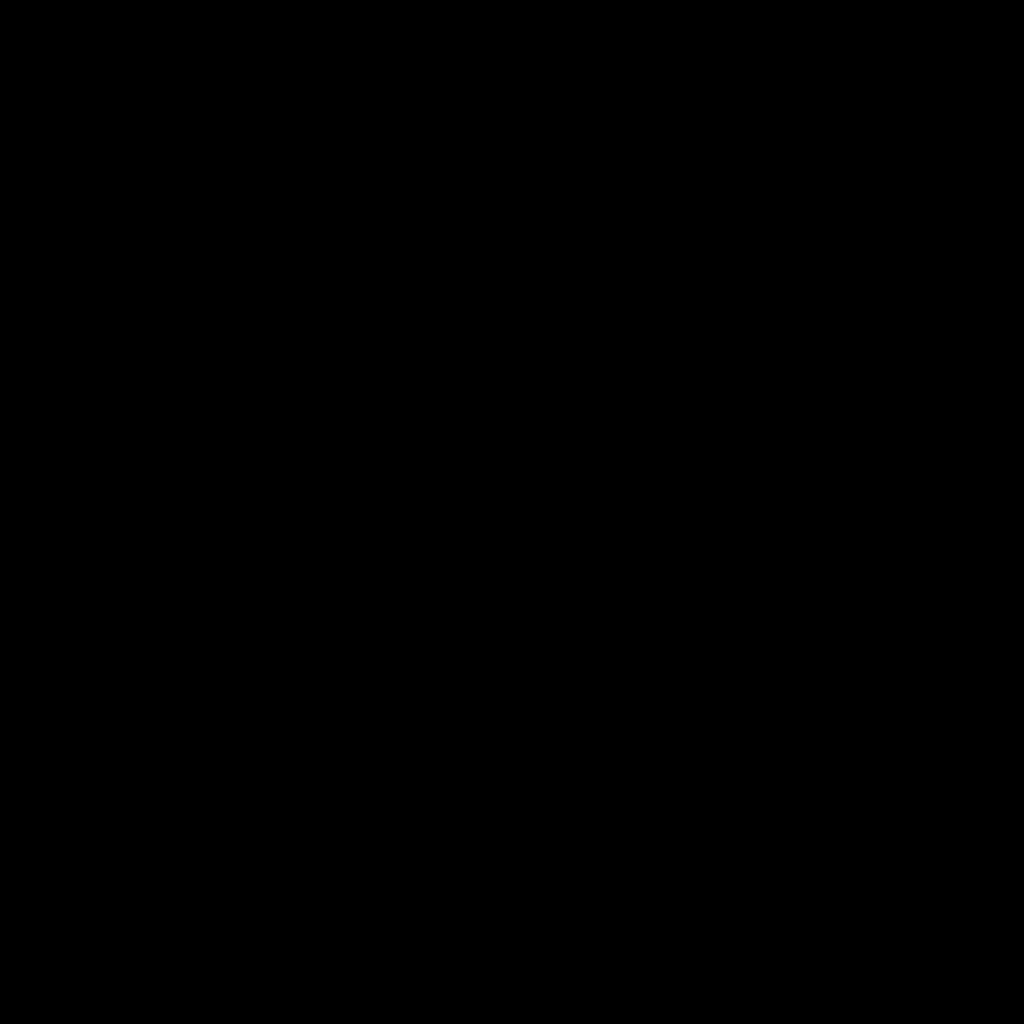

In [ ]:
from diffusers import StableDiffusionXLControlNetPipeline, ControlNetModel, AutoencoderKL
from diffusers.schedulers import EulerDiscreteScheduler
import torch
from PIL import Image
import numpy as np
from pathlib import Path

# --- 1. Configuration ---
# Paths to your models
base_model_path = Path("./../Juggernaut-XL-v9")
controlnet_path = Path("./controlnet_recolor_finetuned")

# Inference settings
device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16

# --- 2. Load Models and Create Pipeline ---
print("Loading models...")

# Load the fine-tuned ControlNet model
controlnet = ControlNetModel.from_pretrained(controlnet_path, torch_dtype=dtype)

# Load the VAE separately. For SDXL, it's often best to use a float32 VAE for better precision.
vae = AutoencoderKL.from_pretrained(base_model_path / "vae", torch_dtype=dtype)

# Load the full pipeline, passing our custom ControlNet and VAE
pipe = StableDiffusionXLControlNetPipeline.from_pretrained(
    base_model_path,
    controlnet=controlnet,
    vae=vae,
    torch_dtype=dtype,
    use_safetensors=True,
)
pipe.to(device)

# Optional: Use a faster scheduler for quicker inference
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

print("Models loaded successfully.")

# --- 3. Prepare Input Image ---
# Load a sample black-and-white image to colorize
# Using an image from the training set as an example
bw_image_path = "./dataset/train/img0.jpg" 
print(f"Loading image: {bw_image_path}")
bw_image = Image.open(bw_image_path).convert("RGB")
bw_image = bw_image.resize((1024, 1024)) # Resize to the resolution used during training

# --- 4. Run Inference ---
# Define the prompt and negative prompt
prompt = "a beautiful, vibrant, detailed, high-resolution, color photo of the scene,"
negative_prompt = "monochrome, black and white, grayscale, ugly, blurry, low quality, watermark, text"

# Set a seed for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

print("Running inference...")
# Run the pipeline
colorized_image = pipe(
    prompt,
    negative_prompt=negative_prompt,
    image=bw_image,
    controlnet_conditioning_scale=0.85, # Adjust this value (0.0 to 1.0) to control the influence of the ControlNet
    generator=generator,
    num_inference_steps=25, # Number of steps for the sampler
).images[0]

print("Inference complete.")

# --- 5. Display and Save the Result ---
# Display the final image in the notebook
display(colorized_image)